In [1]:
import tensorflow as tf
import math
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data as mnist_data
from sklearn.model_selection import train_test_split
from tensorflow.python.framework import ops
import numpy as np
import pandas as pd
print("Tensorflow version " + tf.__version__)
%matplotlib inline
tf.set_random_seed(0)
np.random.seed(1)

Tensorflow version 1.2.1


In [2]:
def load_tf_data():
    mnist = mnist_data.read_data_sets("data", one_hot=True, reshape=False, validation_size=0)
    X_train = mnist.train.images
    Y_train = mnist.train.labels
    X_test = mnist.test.images
    Y_test = mnist.test.labels
    return X_train, X_test, Y_train, Y_test

In [3]:
def load_kaggle_data():
    data = pd.read_csv('input/train.csv')
    X = data.iloc[:,1:].values
    X = X.astype(np.float)
    Y = data.iloc[:,0].values
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=2000, random_state=42)
    X_train = X_train.reshape(-1,28,28,1)/255.
    X_test = X_test.reshape(-1,28,28,1)/255.
    Y_train = np.eye(10)[Y_train.reshape(-1)]
    Y_test = np.eye(10)[Y_test.reshape(-1)]
    return X_train, X_test, Y_train, Y_test

In [53]:
X_train, X_test, Y_train, Y_test = load_tf_data()

Extracting data\train-images-idx3-ubyte.gz
Extracting data\train-labels-idx1-ubyte.gz
Extracting data\t10k-images-idx3-ubyte.gz
Extracting data\t10k-labels-idx1-ubyte.gz


In [54]:
X_train.shape

(60000, 28, 28, 1)

In [55]:
Y_train.shape

(10000, 28, 28, 1)

In [56]:
X_test.shape

(60000, 10)

In [57]:
Y_test.shape

(10000, 10)

In [4]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[0]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:]
    shuffled_Y = Y[permutation,:]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [6]:
def model1(X_train, Y_train, X_test, Y_test,
          num_epochs = 1500, minibatch_size = 32, print_cost = True):
    t=0
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    m = X_train.shape[0]                          # (n_x: input size, m : number of examples in the train set)
    costs = []                                        # To keep track of the cost
    
    # input X: 28x28 grayscale images, the first dimension (None) will index the images in the mini-batch
    X = tf.placeholder(tf.float32, [None, 28, 28, 1])
    # correct answers will go here
    Y = tf.placeholder(tf.float32, [None, 10])
    # variable learning rate
    lr = tf.placeholder(tf.float32)
    # Probability of keeping a node during dropout = 1.0 at test time (no dropout) and 0.75 at training time
    pkeep = tf.placeholder(tf.float32)

    # five layers and their number of neurons (tha last layer has 10 softmax neurons)
    L = 200
    M = 100
    N = 60
    O = 30
    # Weights initialised with small random values between -0.2 and +0.2
    # When using RELUs, make sure biases are initialised with small *positive* values for example 0.1 = tf.ones([K])/10
    W1 = tf.Variable(tf.truncated_normal([784, L], stddev=0.1))  # 784 = 28 * 28
    B1 = tf.Variable(tf.ones([L])/10)
    W2 = tf.Variable(tf.truncated_normal([L, M], stddev=0.1))
    B2 = tf.Variable(tf.ones([M])/10)
    W3 = tf.Variable(tf.truncated_normal([M, N], stddev=0.1))
    B3 = tf.Variable(tf.ones([N])/10)
    W4 = tf.Variable(tf.truncated_normal([N, O], stddev=0.1))
    B4 = tf.Variable(tf.ones([O])/10)
    W5 = tf.Variable(tf.truncated_normal([O, 10], stddev=0.1))
    B5 = tf.Variable(tf.zeros([10]))
    
    parameters = {"W1": W1,
                  "B1": B1,
                  "W2": W2,
                  "B2": B2,
                  "W3": W3,
                  "B3": B3,
                  "W4": W4,
                  "B4": B4,
                  "W5": W5,
                  "B5": B5}

    # The model, with dropout at each layer
    XX = tf.reshape(X, [-1, 28*28])

    Y1 = tf.nn.relu(tf.matmul(XX, W1) + B1)
    Y1d = tf.nn.dropout(Y1, pkeep)

    Y2 = tf.nn.relu(tf.matmul(Y1d, W2) + B2)
    Y2d = tf.nn.dropout(Y2, pkeep)

    Y3 = tf.nn.relu(tf.matmul(Y2d, W3) + B3)
    Y3d = tf.nn.dropout(Y3, pkeep)

    Y4 = tf.nn.relu(tf.matmul(Y3d, W4) + B4)
    Y4d = tf.nn.dropout(Y4, pkeep)

    Ylogits = tf.matmul(Y4d, W5) + B5
#     Y = tf.nn.softmax(Ylogits)

    # Cost function: Add cost function to tensorflow graph
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Ylogits, labels = Y))

    # training step, the learning rate is a placeholder
    optimizer = tf.train.AdamOptimizer(lr).minimize(cost)

    # init
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:
                # set learning rate decay
                max_learning_rate = 0.003
                min_learning_rate = 0.0001
                decay_speed = 2000.0 # 0.003-0.0001-2000=>0.9826 done in 5000 iterations
                learning_rate = min_learning_rate + (max_learning_rate - min_learning_rate) * math.exp(-t/decay_speed)
                t += 1
                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                ### START CODE HERE ### (1 line)
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y,
                                                                            pkeep: 0.75, lr: learning_rate})
                ### END CODE HERE ###
                
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 1 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        correct_prediction = tf.equal(tf.argmax(Ylogits, 1), tf.argmax(Y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train, pkeep: 1}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test, pkeep: 1}))
        
        return parameters

In [7]:
def batchnorm(Ylogits, is_test, iteration, offset, convolutional=False):
    exp_moving_avg = tf.train.ExponentialMovingAverage(0.999, iteration) # adding the iteration prevents from averaging across non-existing iterations
    bnepsilon = 1e-5
    if convolutional:
        mean, variance = tf.nn.moments(Ylogits, [0, 1, 2])
    else:
        mean, variance = tf.nn.moments(Ylogits, [0])
    update_moving_everages = exp_moving_avg.apply([mean, variance])
    m = tf.cond(is_test, lambda: exp_moving_avg.average(mean), lambda: mean)
    v = tf.cond(is_test, lambda: exp_moving_avg.average(variance), lambda: variance)
    Ybn = tf.nn.batch_normalization(Ylogits, m, v, offset, None, bnepsilon)
    return Ybn, update_moving_everages

def model2(X_train, Y_train, X_test, Y_test,
          num_epochs = 1500, minibatch_size = 32, print_cost = True):
    t=0
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             
    seed = 3                                          
    m = X_train.shape[0]                          
    costs = []                                        # To keep track of the cost
    
    # input X: 28x28 grayscale images, the first dimension (None) will index the images in the mini-batch
    X = tf.placeholder(tf.float32, [None, 28, 28, 1])
    # correct answers will go here
    Y = tf.placeholder(tf.float32, [None, 10])
    # variable learning rate
    lr = tf.placeholder(tf.float32)
    # train/test selector for batch normalisation
    tst = tf.placeholder(tf.bool)
    # training iteration
    itr = tf.placeholder(tf.int32)
    # Probability of keeping a node during dropout = 1.0 at test time (no dropout) and 0.75 at training time
    pkeep = tf.placeholder(tf.float32)

    # five layers and their number of neurons (tha last layer has 10 softmax neurons)
    L = 200
    M = 100
    N = 60
    O = 30
    # Weights initialised with small random values between -0.2 and +0.2
    # When using RELUs, make sure biases are initialised with small *positive* values for example 0.1 = tf.ones([K])/10
    W1 = tf.Variable(tf.truncated_normal([784, L], stddev=0.1))  # 784 = 28 * 28
    B1 = tf.Variable(tf.ones([L])/10)
    W2 = tf.Variable(tf.truncated_normal([L, M], stddev=0.1))
    B2 = tf.Variable(tf.ones([M])/10)
    W3 = tf.Variable(tf.truncated_normal([M, N], stddev=0.1))
    B3 = tf.Variable(tf.ones([N])/10)
    W4 = tf.Variable(tf.truncated_normal([N, O], stddev=0.1))
    B4 = tf.Variable(tf.ones([O])/10)
    W5 = tf.Variable(tf.truncated_normal([O, 10], stddev=0.1))
    B5 = tf.Variable(tf.zeros([10]))
    
    parameters = {"W1": W1,
                  "B1": B1,
                  "W2": W2,
                  "B2": B2,
                  "W3": W3,
                  "B3": B3,
                  "W4": W4,
                  "B4": B4,
                  "W5": W5,
                  "B5": B5}

    # The model
    XX = tf.reshape(X, [-1, 784])

    # batch norm scaling is not useful with relus
    # batch norm offsets are used instead of biases

    Y1l = tf.matmul(XX, W1)
    Y1bn, update_ema1 = batchnorm(Y1l, tst, itr, B1)
    Y1 = tf.nn.relu(Y1bn)
    Y1d = tf.nn.dropout(Y1, pkeep)

    Y2l = tf.matmul(Y1d, W2)
    Y2bn, update_ema2 = batchnorm(Y2l, tst, itr, B2)
    Y2 = tf.nn.relu(Y2bn)
    Y2d = tf.nn.dropout(Y2, pkeep)

    Y3l = tf.matmul(Y2d, W3)
    Y3bn, update_ema3 = batchnorm(Y3l, tst, itr, B3)
    Y3 = tf.nn.relu(Y3bn)
    Y3d = tf.nn.dropout(Y3, pkeep)

    Y4l = tf.matmul(Y3d, W4)
    Y4bn, update_ema4 = batchnorm(Y4l, tst, itr, B4)
    Y4 = tf.nn.relu(Y4bn)
    Y4d = tf.nn.dropout(Y4, pkeep)

    Ylogits = tf.matmul(Y4d, W5) + B5

    update_ema = tf.group(update_ema1, update_ema2, update_ema3, update_ema4)

    # Cost function: Add cost function to tensorflow graph
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Ylogits, labels = Y))

    # training step, the learning rate is a placeholder
    optimizer = tf.train.AdamOptimizer(lr).minimize(cost)

    # init
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:
                # set learning rate decay
                max_learning_rate = 0.003
                min_learning_rate = 0.0001
                decay_speed = 2000.0 # 0.003-0.0001-2000=>0.9826 done in 5000 iterations
                learning_rate = min_learning_rate + (max_learning_rate - min_learning_rate) * math.exp(-t/decay_speed)
                t += 1
                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                _ , minibatch_cost = sess.run([optimizer,cost], {X:minibatch_X, Y:minibatch_Y, pkeep:1,
                                                                 lr: learning_rate, tst: False})
                sess.run(update_ema, {X:minibatch_X, Y:minibatch_Y, tst: False, itr: t, pkeep:1})
                
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 1 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        correct_prediction = tf.equal(tf.argmax(Ylogits, 1), tf.argmax(Y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train, pkeep: 1,tst: False}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test, pkeep: 1,tst: False}))
        
        return parameters

In [5]:
def model3(X_train, Y_train, X_test, Y_test,
          num_epochs = 1500, minibatch_size = 32, print_cost = True):
    t=0
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    m = X_train.shape[0]                          # (n_x: input size, m : number of examples in the train set)
    costs = []                                        # To keep track of the cost
    
    # input X: 28x28 grayscale images, the first dimension (None) will index the images in the mini-batch
    X = tf.placeholder(tf.float32, [None, 28, 28, 1])
    # correct answers will go here
    Y = tf.placeholder(tf.float32, [None, 10])
    # variable learning rate
    lr = tf.placeholder(tf.float32)
    # Probability of keeping a node during dropout = 1.0 at test time (no dropout) and 0.75 at training time
    pkeep = tf.placeholder(tf.float32)

    # three convolutional layers with their channel counts, and a
    # fully connected layer (the last layer has 10 softmax neurons)
    K = 6  # first convolutional layer output depth
    L = 12  # second convolutional layer output depth
    M = 24  # third convolutional layer
    N = 200  # fully connected layer

    W1 = tf.Variable(tf.truncated_normal([6, 6, 1, K], stddev=0.1))  # 6x6 patch, 1 input channel, K output channels
    B1 = tf.Variable(tf.constant(0.1, tf.float32, [K]))
    W2 = tf.Variable(tf.truncated_normal([5, 5, K, L], stddev=0.1))
    B2 = tf.Variable(tf.constant(0.1, tf.float32, [L]))
    W3 = tf.Variable(tf.truncated_normal([4, 4, L, M], stddev=0.1))
    B3 = tf.Variable(tf.constant(0.1, tf.float32, [M]))

    W4 = tf.Variable(tf.truncated_normal([7 * 7 * M, N], stddev=0.1))
    B4 = tf.Variable(tf.constant(0.1, tf.float32, [N]))
    W5 = tf.Variable(tf.truncated_normal([N, 10], stddev=0.1))
    B5 = tf.Variable(tf.constant(0.1, tf.float32, [10]))
    
    parameters = {"W1": W1,
                  "B1": B1,
                  "W2": W2,
                  "B2": B2,
                  "W3": W3,
                  "B3": B3,
                  "W4": W4,
                  "B4": B4,
                  "W5": W5,
                  "B5": B5}

    # The model
    stride = 1  # output is 28x28
    Y1 = tf.nn.relu(tf.nn.conv2d(X, W1, strides=[1, stride, stride, 1], padding='SAME') + B1)
    stride = 2  # output is 14x14
    Y2 = tf.nn.relu(tf.nn.conv2d(Y1, W2, strides=[1, stride, stride, 1], padding='SAME') + B2)
    stride = 2  # output is 7x7
    Y3 = tf.nn.relu(tf.nn.conv2d(Y2, W3, strides=[1, stride, stride, 1], padding='SAME') + B3)

    # reshape the output from the third convolution for the fully connected layer
    YY = tf.reshape(Y3, shape=[-1, 7 * 7 * M])

    Y4 = tf.nn.relu(tf.matmul(YY, W4) + B4)
    YY4 = tf.nn.dropout(Y4, pkeep)
    Ylogits = tf.matmul(YY4, W5) + B5

    # Cost function: Add cost function to tensorflow graph
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Ylogits, labels = Y))

    # training step, the learning rate is a placeholder
    optimizer = tf.train.AdamOptimizer(lr).minimize(cost)

    # init
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:
                # set learning rate decay
                max_learning_rate = 0.003
                min_learning_rate = 0.0001
                decay_speed = 2000.0 # 0.003-0.0001-2000=>0.9826 done in 5000 iterations
                learning_rate = min_learning_rate + (max_learning_rate - min_learning_rate) * math.exp(-t/decay_speed)
                t += 1
                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                ### START CODE HERE ### (1 line)
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y,
                                                                            pkeep: 0.75, lr: learning_rate})
                ### END CODE HERE ###
                
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 1 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        correct_prediction = tf.equal(tf.argmax(Ylogits, 1), tf.argmax(Y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train, pkeep: 1}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test, pkeep: 1}))
        
        
        return parameters

In [9]:
def no_batchnorm(Ylogits, is_test, iteration, offset, convolutional=False):
    return Ylogits, tf.no_op()

def compatible_convolutional_noise_shape(Y):
    noiseshape = tf.shape(Y)
    noiseshape = noiseshape * tf.constant([1,0,0,1]) + tf.constant([0,1,1,0])
    return noiseshape

def model4(X_train, Y_train, X_test, Y_test,
          num_epochs = 1500, minibatch_size = 32, print_cost = True):
    t=0
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             
    seed = 3                                          
    m = X_train.shape[0]                          
    costs = []                                        # To keep track of the cost
    
    # input X: 28x28 grayscale images, the first dimension (None) will index the images in the mini-batch
    X = tf.placeholder(tf.float32, [None, 28, 28, 1])
    # correct answers will go here
    Y = tf.placeholder(tf.float32, [None, 10])
    # variable learning rate
    lr = tf.placeholder(tf.float32)
    # train/test selector for batch normalisation
    tst = tf.placeholder(tf.bool)
    # training iteration
    itr = tf.placeholder(tf.int32)
    # Probability of keeping a node during dropout = 1.0 at test time (no dropout) and 0.75 at training time
    pkeep = tf.placeholder(tf.float32)
    pkeep_conv = tf.placeholder(tf.float32)

    # three convolutional layers with their channel counts, and a
    # fully connected layer (tha last layer has 10 softmax neurons)
    K = 24  # first convolutional layer output depth
    L = 48  # second convolutional layer output depth
    M = 64  # third convolutional layer
    N = 200  # fully connected layer

    W1 = tf.Variable(tf.truncated_normal([6, 6, 1, K], stddev=0.1))  # 6x6 patch, 1 input channel, K output channels
    B1 = tf.Variable(tf.constant(0.1, tf.float32, [K]))
    W2 = tf.Variable(tf.truncated_normal([5, 5, K, L], stddev=0.1))
    B2 = tf.Variable(tf.constant(0.1, tf.float32, [L]))
    W3 = tf.Variable(tf.truncated_normal([4, 4, L, M], stddev=0.1))
    B3 = tf.Variable(tf.constant(0.1, tf.float32, [M]))

    W4 = tf.Variable(tf.truncated_normal([7 * 7 * M, N], stddev=0.1))
    B4 = tf.Variable(tf.constant(0.1, tf.float32, [N]))
    W5 = tf.Variable(tf.truncated_normal([N, 10], stddev=0.1))
    B5 = tf.Variable(tf.constant(0.1, tf.float32, [10]))
    
    parameters = {"W1": W1,
                  "B1": B1,
                  "W2": W2,
                  "B2": B2,
                  "W3": W3,
                  "B3": B3,
                  "W4": W4,
                  "B4": B4,
                  "W5": W5,
                  "B5": B5}

    # The model
    # batch norm scaling is not useful with relus
    # batch norm offsets are used instead of biases
    stride = 1  # output is 28x28
    Y1l = tf.nn.conv2d(X, W1, strides=[1, stride, stride, 1], padding='SAME')
    Y1bn, update_ema1 = batchnorm(Y1l, tst, itr, B1, convolutional=True)
    Y1r = tf.nn.relu(Y1bn)
    Y1 = tf.nn.dropout(Y1r, pkeep_conv, compatible_convolutional_noise_shape(Y1r))
    stride = 2  # output is 14x14
    Y2l = tf.nn.conv2d(Y1, W2, strides=[1, stride, stride, 1], padding='SAME')
    Y2bn, update_ema2 = batchnorm(Y2l, tst, itr, B2, convolutional=True)
    Y2r = tf.nn.relu(Y2bn)
    Y2 = tf.nn.dropout(Y2r, pkeep_conv, compatible_convolutional_noise_shape(Y2r))
    stride = 2  # output is 7x7
    Y3l = tf.nn.conv2d(Y2, W3, strides=[1, stride, stride, 1], padding='SAME')
    Y3bn, update_ema3 = batchnorm(Y3l, tst, itr, B3, convolutional=True)
    Y3r = tf.nn.relu(Y3bn)
    Y3 = tf.nn.dropout(Y3r, pkeep_conv, compatible_convolutional_noise_shape(Y3r))

    # reshape the output from the third convolution for the fully connected layer
    YY = tf.reshape(Y3, shape=[-1, 7 * 7 * M])

    Y4l = tf.matmul(YY, W4)
    Y4bn, update_ema4 = batchnorm(Y4l, tst, itr, B4)
    Y4r = tf.nn.relu(Y4bn)
    Y4 = tf.nn.dropout(Y4r, pkeep)
    Ylogits = tf.matmul(Y4, W5) + B5

    update_ema = tf.group(update_ema1, update_ema2, update_ema3, update_ema4)

    # Cost function: Add cost function to tensorflow graph
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Ylogits, labels = Y))

    # training step, the learning rate is a placeholder
    optimizer = tf.train.AdamOptimizer(lr).minimize(cost)

    # init
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:
                # set learning rate decay
                max_learning_rate = 0.003
                min_learning_rate = 0.0001
                decay_speed = 2000.0 # 0.003-0.0001-2000=>0.9826 done in 5000 iterations
                learning_rate = min_learning_rate + (max_learning_rate - min_learning_rate) * math.exp(-t/decay_speed)
                t += 1
                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                _ , minibatch_cost = sess.run([optimizer,cost], {X:minibatch_X, Y:minibatch_Y, pkeep:0.75, pkeep_conv:1,
                                                                 lr: learning_rate, tst: False})
                sess.run(update_ema, {X:minibatch_X, Y:minibatch_Y, tst: False, itr: t, pkeep:1,pkeep_conv:1})
                
                epoch_cost += minibatch_cost / num_minibatches
                break

            # Print the cost every epoch
            if print_cost == True and epoch % 1 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        correct_prediction = tf.equal(tf.argmax(Ylogits, 1), tf.argmax(Y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train, pkeep: 1,pkeep_conv:1,tst: False}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test, pkeep: 1,pkeep_conv:1,tst: False}))
        
        return parameters

Cost after epoch 0: 0.225864
Cost after epoch 1: 0.064315
Cost after epoch 2: 0.040767
Cost after epoch 3: 0.030529
Cost after epoch 4: 0.020573


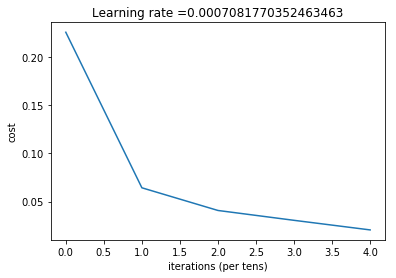

Parameters have been trained!
Train Accuracy: 0.997699
Test Accuracy: 0.988


In [6]:
# X_train, X_test, Y_train, Y_test = load_tf_data()
X_train, X_test, Y_train, Y_test = load_kaggle_data()
parameters = model3(X_train, Y_train, X_test, Y_test, num_epochs = 5, minibatch_size = 64)

In [73]:
def predict3(X_to_predict, parameters):
    
    M = 24  # third convolutional layer
    
    W1 = tf.convert_to_tensor(parameters["W1"])
    B1 = tf.convert_to_tensor(parameters["B1"])
    W2 = tf.convert_to_tensor(parameters["W2"])
    B2 = tf.convert_to_tensor(parameters["B2"])
    W3 = tf.convert_to_tensor(parameters["W3"])
    B3 = tf.convert_to_tensor(parameters["B3"])
    W4 = tf.convert_to_tensor(parameters["W4"])
    B4 = tf.convert_to_tensor(parameters["B4"])
    W5 = tf.convert_to_tensor(parameters["W5"])
    B5 = tf.convert_to_tensor(parameters["B5"])
    
#     params = {"W1": W1,
#               "b1": b1,
#               "W2": W2,
#               "b2": b2,
#               "W3": W3,
#               "b3": b3}
    
    X = tf.placeholder(tf.float32, [None, 28, 28, 1])
    
    # The model
    stride = 1  # output is 28x28
    Y1 = tf.nn.relu(tf.nn.conv2d(X, W1, strides=[1, stride, stride, 1], padding='SAME') + B1)
    stride = 2  # output is 14x14
    Y2 = tf.nn.relu(tf.nn.conv2d(Y1, W2, strides=[1, stride, stride, 1], padding='SAME') + B2)
    stride = 2  # output is 7x7
    Y3 = tf.nn.relu(tf.nn.conv2d(Y2, W3, strides=[1, stride, stride, 1], padding='SAME') + B3)

    # reshape the output from the third convolution for the fully connected layer
    YY = tf.reshape(Y3, shape=[-1, 7 * 7 * M])

    Y4 = tf.nn.relu(tf.matmul(YY, W4) + B4)
#     YY4 = tf.nn.dropout(Y4, pkeep)
    Ylogits = tf.matmul(Y4, W5) + B5
    
    p = tf.argmax(Ylogits,1)
    
    with tf.Session() as sess:
        prediction = sess.run(p, feed_dict = {X: X_to_predict})
        
    return prediction

In [65]:
def load_kaggle_test():
    # read test data from CSV file 
    test_images = pd.read_csv('input/test.csv').values
    test_images = test_images.astype(np.float)

    # convert from [0:255] => [0.0:1.0]
    test_images = test_images.reshape(-1,28,28,1)/255.
    return test_images

In [66]:
test_images = load_kaggle_test()

In [77]:
test_images[0].shape

(28, 28, 1)

In [74]:
prediction = predict3(test_images, parameters)

In [75]:
prediction

array([2, 0, 9, ..., 3, 9, 2], dtype=int64)

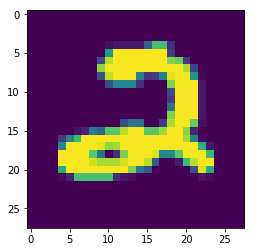

In [78]:
plt.imshow(test_images[0].reshape(28,28))

In [79]:
np.savetxt('submission_model3.csv', 
           np.c_[range(1,len(test_images)+1),prediction], 
           delimiter=',', 
           header = 'ImageId,Label', 
           comments = '', 
           fmt='%d')